### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from time import sleep

### Problem Definition


In [20]:
# Problem Parameters and Cost Function Declaration

NFE = 0         # Number of Function Evaluation

fname = r"pid_gain_err.txt"
f_s = 100
t_S = 1 / f_s
period = 5
setpoint = 30
max_speed = 3500
throttle = 2400

def rms(data):
    return np.sqrt(np.mean(data ** 2))
    

def pidGainEval(gains):
    
    global NFE
    
    # Run the Simulation
    os.system(f"./pidGainEval {throttle} {gains[0]} {gains[1]} {gains[2]} {gains[3]} {max_speed}")
    
    data = np.loadtxt(fname=fname)  # Read Data
    
    if (np.sum(data == 10000) > 0):
        cost = rms(data) * 1000   # Return a Big Cost
        
    else:
        rms_data = rms(data - setpoint)                # Calculating RMS of the Signal
        peak = np.max(data) - setpoint                 # Calculating Peak
        
        # Calculating the Rising Time
        minTime = 0.1 * setpoint
        maxTime = 0.9 * setpoint
        startInd = np.argwhere(data >= minTime)[0]
        endInd = np.argwhere(data >= maxTime)[0]
        
        settleTime = t_S * (endInd - startInd)   # Convert index into time
        
        cost = rms_data * peak * settleTime  # Calculate the Cost
              
    NFE += 1                # Add to the function evaluation Count
    
    os.system(f"mv pid_gain_err.txt flightData/{NFE}.txt")  # Moving the File into the Folder 
    
    sleep(2)                    # Wait for 2 Seconds
    
    return cost

[148.78263445]


In [2]:
cost_func = pidGainEval
n_var = 4                           # Number of decision Vars
var_size = np.array([1, n_var])     # Decision Variable Mat Size
var_min = np.array([-10])           # Desicion Var Lower Bound
var_max = np.array([10])            # Decision Var Upper Bound

### BBO Parameters


In [3]:
max_it = 200                     # Max Number of Iterations
n_pop = 100                      # Number of Habitats

keep_rate = 0.2                         # Keep Rate (Elitism Rate)
n_keep = round(keep_rate * n_pop)       # Number of Kept Habitats (No of Elits)
n_new = n_pop - n_keep                  # Number of New Habitats

### Migeration Rates

In [4]:
mu = np.linspace(1, 0, n_pop)           # Emmigration Rates
lmbda = np.linspace(0, 1, n_pop)        # Immigration Rates

alpha = 0.9
p_mutation = 0.05                       # Mutation Rate
sigma = 0.02 * (var_min - var_max)      # Standard Devision

### Initialization

In [5]:
pop_position = np.zeros((n_pop, n_var))
pop_cost = np.zeros((n_pop))


for iter in range(0, n_pop):
    pop_position[iter, :] = np.random.uniform(var_min, var_max, var_size)
    pop_cost[iter] = cost_func(pop_position[iter, :])

# Function to Sort Population due to Costs
def pop_sort(pos, cost):
    sort_order = np.argsort(cost, axis=0)

    cost = cost[sort_order]
    pos = pos[sort_order]

    return pos, cost

# Sort Population
pop_position, pop_cost = pop_sort(pop_position, pop_cost)

# Store the Best Solution Ever Found
best_sol = pop_position[0, :]
best_cost = np.zeros((max_it))              # Array to Hold Best Costs

# Roulette Wheel Selection (Selection due to Probabilities)1
def roulette_wheel_selection(prob):
    r = np.random.rand() * np.sum(prob)
    cumsum = 0
    for i in range(len(prob)):
        cumsum += prob[i]
        if (cumsum > r):
            return i

### BBO Main Loop

In [6]:
for iter in range(max_it):
    
    # Create a Copy of the Population
    new_pop_cost = pop_cost
    new_pop_pos = pop_position

    for i in range(n_pop):
        for k in range(n_var):
            # Migration
            if np.random.rand() <= lmbda[i]:
                # Modify Emmigration Probabilities
                EP = mu
                EP[i] = 0
                EP /= np.sum(EP)                # Normalize it!
                
                # Select Source Habitat
                j = roulette_wheel_selection(EP)
                
                # Migration
                new_pop_pos[i, k] = pop_position[i, k] 
                + alpha * (pop_position[j, k] - pop_position[i, k])
            
            # Mutation
            if np.random.rand() <= p_mutation:
                new_pop_pos[i, k] += sigma * np.random.randn(1)
            
        # Evaluation
        new_pop_cost[i] = cost_func(new_pop_pos[i, :])
    
    # Sort New Population
    new_pop_pos, new_pop_cost = pop_sort(new_pop_pos, new_pop_cost)
    
    # Select Next Iteration Population
    pop_position = np.concatenate((pop_position[0:n_keep, :], new_pop_pos[0:n_new, :]), axis=0)
    pop_cost = np.concatenate((pop_cost[0:n_keep], new_pop_cost[0:n_new]), axis = 0)
    
    # Sort Population
    pop_position, pop_cost = pop_sort(pop_position, pop_cost)
    
    # Update Best Solution Ever Found
    best_sol = pop_position[0, :]
    
    # Store Best Cost Ever Found
    best_cost[iter] = pop_cost[0]
    
    # Log Iteration Info
    print(f"Iteration {iter}: Best Cost = {best_cost[iter]}")

Iteration 0: Best Cost = 43.663545298575805
Iteration 1: Best Cost = 39.76532677588497
Iteration 2: Best Cost = 39.76532677588497
Iteration 3: Best Cost = 39.76532677588497
Iteration 4: Best Cost = 32.67370364000471
Iteration 5: Best Cost = 32.67370364000471
Iteration 6: Best Cost = 32.67370364000471
Iteration 7: Best Cost = 31.382523161795675
Iteration 8: Best Cost = 31.382523161795675
Iteration 9: Best Cost = 30.937882075351265
Iteration 10: Best Cost = 28.580617395250545
Iteration 11: Best Cost = 28.580617395250545
Iteration 12: Best Cost = 27.11650033209456
Iteration 13: Best Cost = 27.11650033209456
Iteration 14: Best Cost = 24.700707467083596
Iteration 15: Best Cost = 24.683536801231035
Iteration 16: Best Cost = 24.683536801231035
Iteration 17: Best Cost = 24.109223610669314
Iteration 18: Best Cost = 24.109223610669314
Iteration 19: Best Cost = 22.736597749636232
Iteration 20: Best Cost = 20.844985825483217
Iteration 21: Best Cost = 20.42837741136668
Iteration 22: Best Cost = 19.

### Results

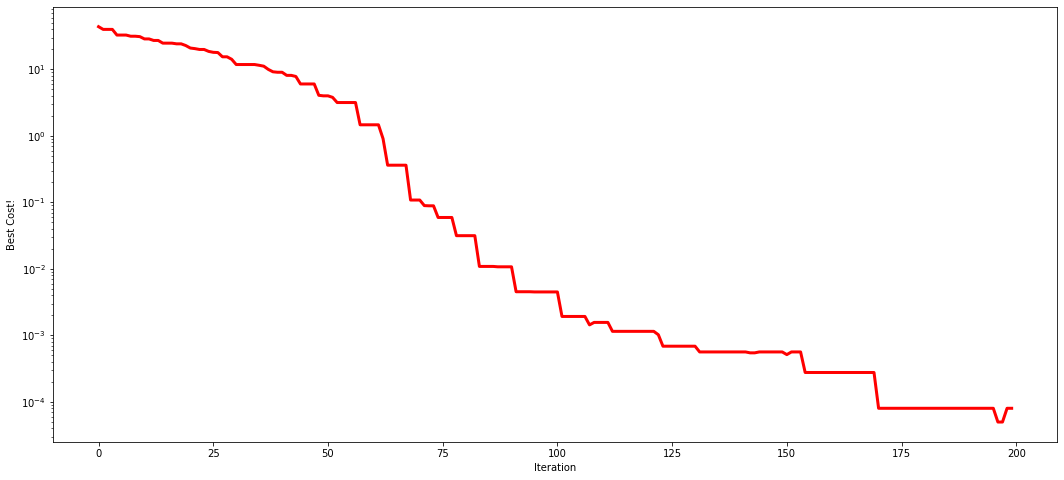

In [7]:
fig = plt.figure(figsize=(18,8));
plt.semilogy(best_cost, linewidth=3, color='r');
plt.xlabel("Iteration");
plt.ylabel("Best Cost!");